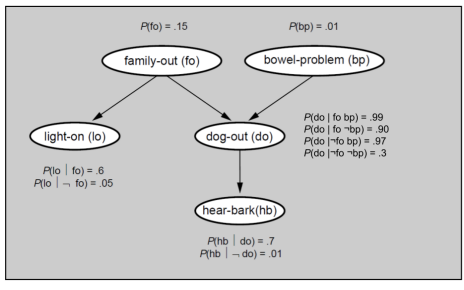

In [1]:
import pomegranate as pg

# create root node (fo) and (bp)
# fo has 15% chance of being true, 85% false
#section 3.1.1
fo = pg.DiscreteDistribution({'family out': 0.15, 'family home': 0.85})
bp = pg.DiscreteDistribution({'bowel problem': 0.01, 'no bowel problem': 0.99})

#section 3.1.2
lo = pg.ConditionalProbabilityTable(
        [[ 'family home', 'light off', 0.95 ],
         [ 'family home', 'light on', 0.05 ],
         [ 'family out', 'light off', 0.4 ],
         [ 'family out', 'light on', 0.6 ]],[fo]) 

do = pg.ConditionalProbabilityTable(
        [[ 'family home', 'no bowel problem', 'dog out', 0.3 ],
         [ 'family home', 'bowel problem', 'dog out', 0.97 ],
         [ 'family out', 'no bowel problem', 'dog out', 0.9 ],
         [ 'family out', 'bowel problem', 'dog out', 0.99 ],
         [ 'family home', 'no bowel problem', 'dog in', 0.7 ],
         [ 'family home', 'bowel problem', 'dog in', 0.03 ],
         [ 'family out', 'no bowel problem', 'dog in', 0.1 ],
         [ 'family out', 'bowel problem', 'dog in', 0.01 ]],[fo,bp]) 

hb = pg.ConditionalProbabilityTable(
        [[ 'dog in', 'no hear bark', 0.99 ],
         [ 'dog in', 'hear bark', 0.01 ],
         [ 'dog out', 'no hear bark', 0.3 ],
         [ 'dog out', 'hear bark', 0.7 ]],[do])


In [2]:
model = pg.BayesianNetwork("MyBN")

FO = pg.State(fo, name="FO")
BP = pg.State(bp, name="BP")
LO = pg.State(lo, name="LO")
DO = pg.State(do, name="DO")
HB = pg.State(hb, name="HB")

# 5 states
model.add_states(FO, BP, LO, DO, HB)

# add edges, make sure direction is correct
model.add_edge(FO, LO)
model.add_edge(FO, DO)
model.add_edge(DO, HB)
model.add_edge(BP, DO)

In [3]:
model.bake() # finalize model

In [4]:
#section 3.1.7
#P(~FO,BP,~LO,DO,HB)
print(model.probability([["family home", "bowel problem", "light off", "dog out", "hear bark"]]))

#P(DO|BP)
# parameters[0] is the probability table
# {bp: 'bowel problem'} is the evidence
# [3] is the index of the DO state
# [0] is the index of the probability table
print(model.predict_proba([{'BP': 'bowel problem'}])[0][3].parameters[0]['dog out'])

#P(~BP|~DO)
print(model.predict_proba([{'DO': 'dog in'}])[0][1].parameters[0]['no bowel problem'])

0.0054829250000000005
0.9729999999999995
0.9995531059138985


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# create the fuzzy variables
# • Speed: from 0 to 150.
# • Temperature: from 0 to 150.
# • Injection: from 0 to 100.

# antecedent variables (input/sensor)
speed = ctrl.Antecedent(np.arange(0, 151, 1), 'speed')
temperature = ctrl.Antecedent(np.arange(0, 151, 1), 'temperature')

# consequence variable (output - control)
injection = ctrl.Consequent(np.arange(0, 101, 1), 'injection', defuzzify_method='centroid')


In [6]:
# create the membership functions

# speed - low, medium, high
# trapmf: trapezoidal membership function
# [0, 0, 25, 60] means 0 at 0, 0 at 0, 1 at 25, 0 at 60 (trapezoidal shape)
speed['low'] = fuzz.trapmf(speed.universe, [0, 0, 25, 60])
# [25, 75, 125] means 0 at 25, 1 at 75, 0 at 125 (triangular shape)
# trimf: triangular membership function
speed['medium'] = fuzz.trimf(speed.universe, [25, 75, 125])
# [60, 100, 150, 150] means 0 at 60, 1 at 100, 0 at 150 (trapezoidal shape)
speed['high'] = fuzz.trapmf(speed.universe, [60, 100, 150, 150])

# temperature - low, medium, high
temperature['low'] = fuzz.trapmf(temperature.universe, [0, 0, 25, 60])
temperature['medium'] = fuzz.trimf(temperature.universe, [25, 75, 125])
temperature['high'] = fuzz.trapmf(temperature.universe, [60, 100, 150, 150])

# injection - low, medium, high
injection['low'] = fuzz.trimf(injection.universe, [0, 0, 30])
injection['medium'] = fuzz.trimf(injection.universe, [10, 50, 90])
injection['high'] = fuzz.trimf(injection.universe, [70, 100, 100])

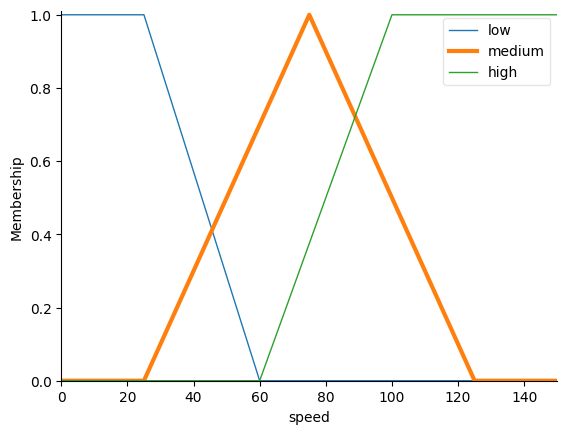

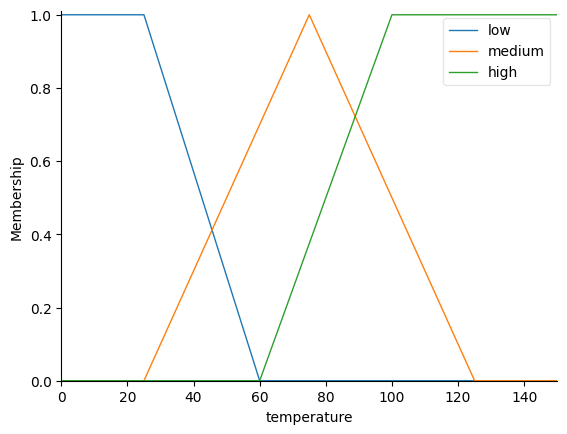

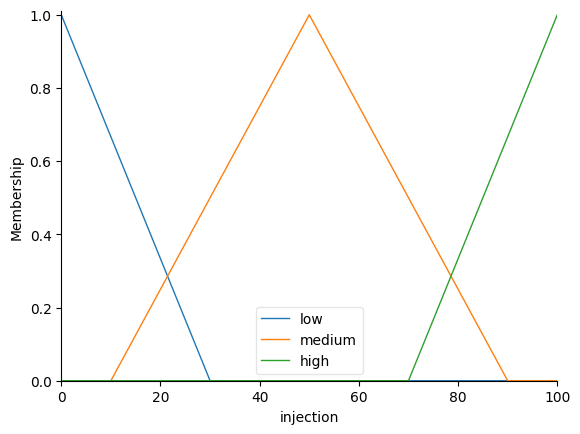

In [9]:
# visualize the membership functions
# speed.view()
speed['medium'].view() # highlight the medium membership function
temperature.view()
injection.view()



88.33333333333333
37.89285714285711


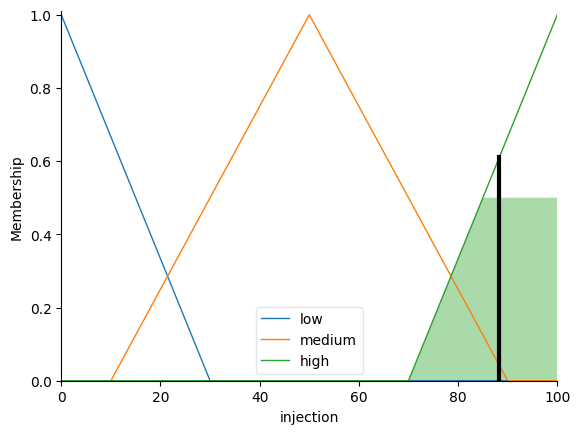

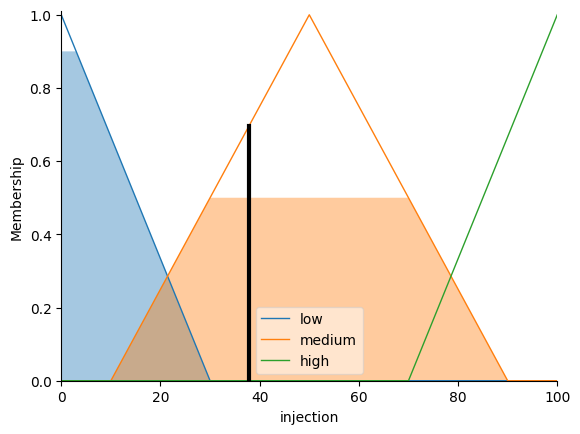

In [11]:
# create the rules
rule1 = ctrl.Rule(speed['low'] & temperature['low'], injection['high'])
rule2 = ctrl.Rule(speed['low'] & temperature['medium'], injection['high'])
rule3 = ctrl.Rule(speed['low'] & temperature['high'], injection['medium'])

rule4 = ctrl.Rule(speed['medium'] & temperature['low'], injection['high'])
rule5 = ctrl.Rule(speed['medium'] & temperature['medium'], injection['medium'])
rule6 = ctrl.Rule(speed['medium'] & temperature['high'], injection['low'])

rule7 = ctrl.Rule(speed['high'] & temperature['low'], injection['medium'])
rule8 = ctrl.Rule(speed['high'] & temperature['medium'], injection['low'])
rule9 = ctrl.Rule(speed['high'] & temperature['high'], injection['low'])


injection_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])

injection_sim = ctrl.ControlSystemSimulation(injection_ctrl)

#section 4.1.6
injection_sim.input['speed'] = 50 # between low and medium
injection_sim.input['temperature'] = 10 # low
# calculate injection level when speed is 50 and temperature is 10
# apply rule, injection should be high
# calculate the centroid of the output membership function
injection_sim.compute()

# Results and visualization.
print(injection_sim.output['injection'])
injection.view(sim=injection_sim)

# test 2
# speed is high, temperature is high
# injection should be low
injection_sim.input['speed'] = 70
injection_sim.input['temperature'] = 100
injection_sim.compute()

print(injection_sim.output['injection'])
injection.view(sim=injection_sim)


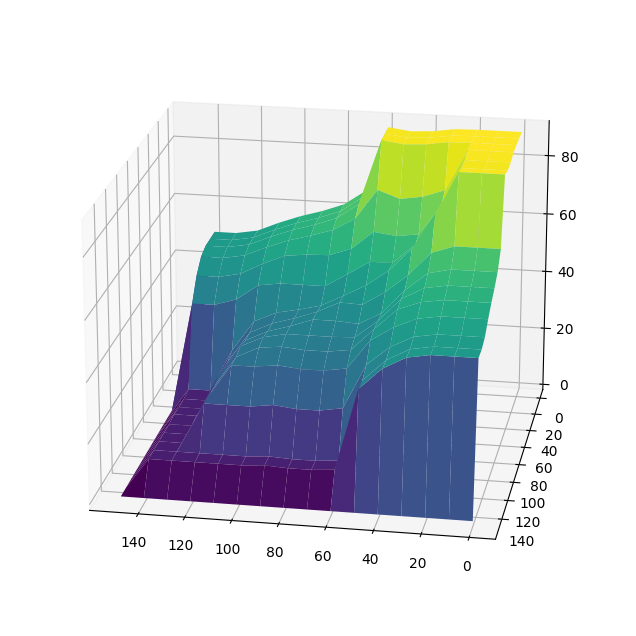

In [13]:
upsampled = np.linspace(0, 150, 16)
x, y = np.meshgrid(upsampled, upsampled)
z = np.zeros_like(x)

#collect injections for the control surface
for i in range(15):
    for j in range(15):
        injection_sim.input['speed'] = x[i, j]
        injection_sim.input['temperature'] = y[i, j]
        injection_sim.compute()
        z[i, j] = injection_sim.output['injection']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

ax.view_init(20, 100)

Membership at 72.5% 0.6428571428571428


c:\Users\Nguyen Hai Duong\anaconda3\envs\python_pomegranate\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


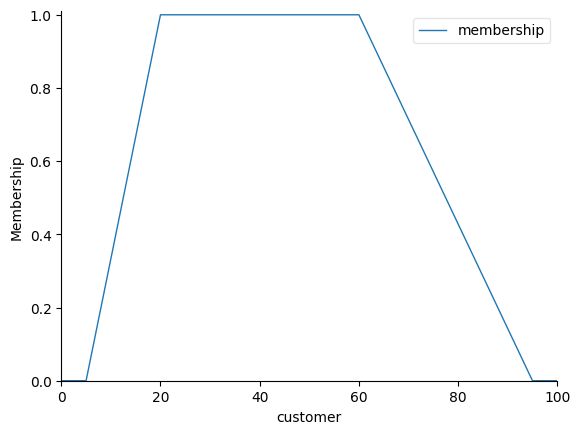

In [26]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl

# Define the Antecedent
customer = ctrl.Antecedent(np.arange(0, 101, 1), 'customer')

# Define the trapezoidal membership function
customer_membership = fuzz.trapmf(customer.universe, [5, 20, 60, 95])

# Calculate the membership value for 72.5%
membership_value = fuzz.interp_membership(customer.universe, customer_membership, 72.5)

# Print the result
print('Membership at 72.5%:',membership_value)

customer['membership'] = fuzz.trapmf(customer.universe, [5, 20, 60, 95])
# view the membership function
customer.view()